# Looking into the 3 CAVIAR "outliers"

Here we want to understand the examples that CAVIAR `-c 1` and susie `L 1` do not agree for `n = 1` causal variable.

The plan is to pin-point the data in question and get the corresponding data-set, then use interactive analysis to explore in detail.

## Extract simulated dataset

In [1]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/Documents/GIT/github/mvarbvs/dsc

In [ ]:
dataset = c('~/Documents/GTExV8/Toys/Thyroid.ENSG00000144445.RDS', '~/Documents/GTExV8/Toys/Thyroid.ENSG00000155324.RDS', '~/Documents/GTExV8/Toys/Thyroid.ENSG00000156738.RDS')
out = dscrutils::dscquery('susie_comparison', 
                          targets = "liter_data.dataset lm_less.n_signal lm_less", 
                          conditions = "lm_less.n_signal = 1")

In [9]:
out[which(out$liter_data.dataset %in% dataset),]

,DSC,liter_data.dataset,lm_less.n_signal,lm_less.output.file
39,1,~/Documents/GTExV8/Toys/Thyroid.ENSG00000144445.RDS,1,lm_less/liter_data_39_summarize_ld_1_lm_less_1
48,1,~/Documents/GTExV8/Toys/Thyroid.ENSG00000155324.RDS,1,lm_less/liter_data_48_summarize_ld_1_lm_less_1
49,1,~/Documents/GTExV8/Toys/Thyroid.ENSG00000156738.RDS,1,lm_less/liter_data_49_summarize_ld_1_lm_less_1


In [11]:
bash:
    cp susie_comparison/lm_less/liter_data_{39,48,49}_summarize_ld_1_lm_less_1.pkl ../data

## The `ENSG00000156738` example

Here I take one data-set and use narratives to work all the way to the point we get CAVIAR and susie results. Hopefully this transparent process will help us pin-pointing the problem.

Load data first:

In [3]:
name = 'ENSG00000156738'
prefix = paste0("/tmp/", name, '_CAVIAR')

In [4]:
dat = dscrutils:::read_dsc('../data/liter_data_49_summarize_ld_1_lm_less_1.pkl')$data

### Data preparation

In [5]:
names(dat)

[1] "X"                 "y"                 "Z"                
 [4] "chrom"             "pos"               "true_coef"        
 [7] "residual_variance" "Y"                 "allele_freq"      
[10] "V"

In [7]:
dim(dat$X)

[1]  574 1001

The data has two response variables. We will focus on `Y[,1]`:

In [8]:
dim(dat$Y)

[1] 574   2

The true signal is `816`.

In [9]:
which(dat$true_coef[,1] != 0)

[1] 816

Now output LD and summary stats for CAVIAR

In [10]:
r2 = cor(dat$X)
r2 = r2 ^ 2 * sign(r2)
write.table(r2,paste0(prefix, '.ld'),quote=F,col.names=F,row.names=F)

In [11]:
source('modules/regression.R')
source('modules/fit_caviar.R')
res = mm_regression(as.matrix(dat$X), as.matrix(dat$Y))
z_score = res[1,,]/res[2,,]
cfg = write_caviar_sumstats(z_score, prefix)

### CAVIAR

Now run CAVIAR, with prior 0.001 for 1 effect in 1000.

In [12]:
cmd = paste("CAVIAR", "-z", cfg$z, "-l", paste0(prefix, ".ld"), "-o", prefix, "-r 0.001")
dscrutils:::run_cmd(cmd)

[1] 0

In [13]:
log <- readLines(cfg$log)
library(dplyr)
library(magrittr)
# read output tables
snp <- read.delim(cfg$post)  
stopifnot(ncol(snp) == 3)
names(snp) <- c("snp", "snp_prob_set", "snp_prob")
snp$snp <- as.character(snp$snp)
snp <- rank_snp(snp)

# `set` of snps
set <- readLines(cfg$set)
set_ordered <- left_join(data_frame(snp = set), snp, by = "snp") %>% 
arrange(rank) %$% snp


Attaching package: ‘dplyr’
The following objects are masked from ‘package:stats’:

    filter, lag
The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


In [15]:
set_ordered

[1] "816"

In [16]:
head(snp)

rank,snp,snp_prob,snp_prob_cumsum,snp_prob_set
1,816,1.000,0.5000,0.5000
2,769,0.125,0.5625,0.0625
3,770,0.125,0.6250,0.0625
4,771,0.125,0.6875,0.0625
5,791,0.125,0.7500,0.0625
6,796,0.125,0.8125,0.0625


So here CAVIAR reports one set that contains one causal variant `816`. **Notice in the CAVIAR call I did not explicitly specify `-c 1` but I still get this one signal.**

### susie

Set `L=1` for the susie fit, which is just a single effect regression. In sum:

- Susie still picks `816` the top one, as expected, but the PIP is 0.16
- There are 14 other variables have PIP under 0.08

In [17]:
# Here my X and Y are already centered

X = scale(dat$X,center=FALSE, scale=TRUE)
Y = dat$Y[,1]
fit = susieR:::single_effect_regression(Y,X,sa2=0.2,s2=var(dat$Y[,1]))

In [18]:
which.max(fit$alpha)

[1] 816

For L=1 the `alpha` is the PIP:

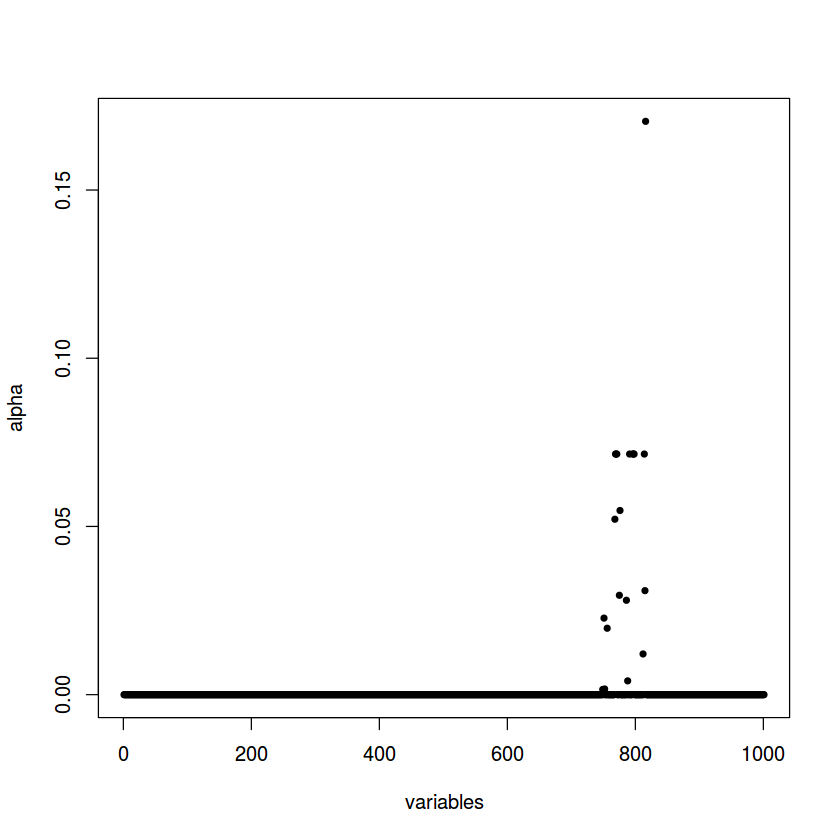

In [21]:
plot(fit$alpha, pch=20, xlab='variables', ylab = 'alpha')

In [23]:
sort(fit$alpha, decreasing=T)[1:10]

[1] 0.17042328 0.07152846 0.07152846 0.07152846 0.07152846 0.07152846
 [7] 0.07152846 0.07152846 0.07152846 0.05474520

Purity of susie CS, defined by the min of abs(LD):

In [28]:
cs = which(susieR:::in_CS_x(fit$alpha)>0)
purity = r2[cs,cs]
purity

1.0000000,0.9963420,0.9969772,0.9969772,0.9969772,0.9939427,0.9963460,0.9939427,0.9969772,0.9969772,0.9969772,0.9969772,0.9969772,0.9939341,0.9933067
0.9963420,1.0000000,0.9993619,0.9993619,0.9993619,0.9963506,0.9987251,0.9963506,0.9993619,0.9993619,0.9993619,0.9993619,0.9993619,0.9963420,0.9957090
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9939427,0.9963506,0.9969858,0.9969858,0.9969858,1.0000000,0.9963545,0.9939513,0.9969858,0.9969858,0.9969858,0.9969858,0.9969858,0.9939427,0.9933153
0.9963460,0.9987251,0.9993658,0.9993658,0.9993658,0.9963545,1.0000000,0.9963545,0.9993658,0.9993658,0.9993658,0.9993658,0.9993658,0.9963460,0.9957130
0.9939427,0.9963506,0.9969858,0.9969858,0.9969858,0.9939513,0.9963545,1.0000000,0.9969858,0.9969858,0.9969858,0.9969858,0.9969858,0.9939427,0.9933153
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467
0.9969772,0.9993619,1.0000000,1.0000000,1.0000000,0.9969858,0.9993658,0.9969858,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,0.9969772,0.9963467


In [29]:
length(cs)

[1] 15

In [31]:
min(abs(purity))

[1] 0.9933067

### Susie BF's


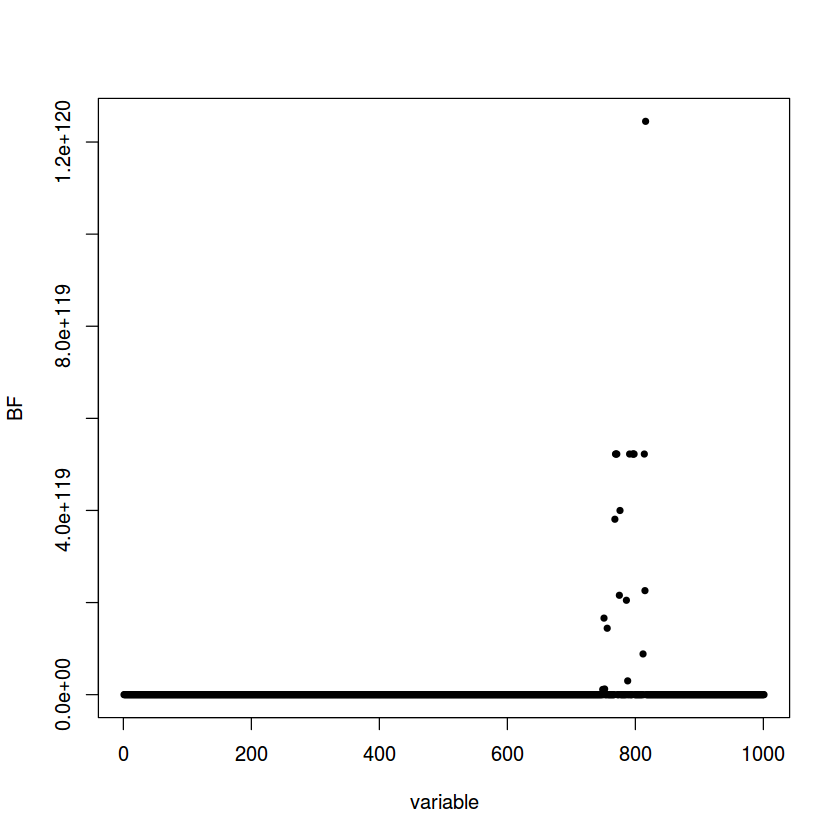

In [35]:
plot(exp(fit$lbf), pch = 20, ylab = 'BF', xlab = 'variable')